In [1]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT,WaveletN, OWL
from modopt.opt.proximity import GroupLASSO, IdentityProx

from online.generators.column import Column2DKspaceGenerator,  DataOnlyKspaceGenerator
from online.reconstructors import OnlineReconstructor
from online.operators.fourier import ColumnFFT
from utils import implot, load_data, create_cartesian_metrics
from online.metrics import ssos, psnr_ssos

/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


In [2]:
DATA_DIR = "data/"
N_JOBS = 1
results = dict()


full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
# use mono-coil data
#full_k = sp.fft.ifftshift(sp.fft.fft2(real_img,s=(320,320),norm="ortho"))
#final_mask = crop_center_square(final_mask)
final_k = full_k * final_mask[np.newaxis,...]


(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


# Type I reconstruction

In [3]:
kspace_gen = Column2DKspaceGenerator(final_k,mask_cols=mask_loc)
K_DIM = kspace_gen.shape[-2:]
N_COILS = kspace_gen.shape[0] if full_k.ndim == 3 else 1
# The fourier Operator apply also the sampling mask.
fourier_op = FFT(shape=K_DIM,n_coils=N_COILS, mask=final_mask)
# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
GL_op = GroupLASSO(weights = 0.1)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)
cost_op_kwargs = {'cost_interval': 1}

## Basic inverse transform
Offline reconstruction, no regularisation.

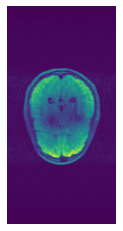

25.301940376154718

In [4]:
base_img = fourier_op.adj_op(final_k)
implot(ssos(base_img))
implot(real_img)
psnr_ssos(base_img,real_img)

Lipschitz constant is 1.1


  0%|          | 0/80 [00:00<?, ?it/s]

 - mu:  0.0005
 - lipschitz constant:  1.1
 - data:  (640, 320)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f92ff70d670> - 4
----------------------------------------


81it [04:11,  3.10s/it]                        


 - final iteration number:  81
 - final cost value:  0.4718299812447396
 - converged:  False
Done.
Execution time:  251.9171859549997  seconds
----------------------------------------


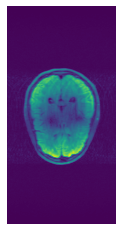

25.29476155789142


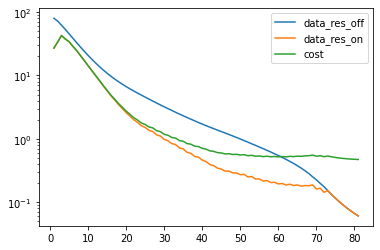

In [5]:
GL_op = GroupLASSO(weights = 5e-4)

online_pb = OnlineReconstructor(fourier_op,
                                linear_op,
                                opt='vanilla',
                                regularizer_op=GL_op,
                                verbose=1)

metrics = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

xf, costs, metrics_results = online_pb.reconstruct(kspace_gen,
                                                   eta=0.1,
                                                   cost_op_kwargs=cost_op_kwargs,
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   )

implot(ssos(xf))
print(psnr_ssos(xf,real_img))
plt.figure()
plt.semilogy(metrics_results['data_res_off']['index'],
         metrics_results['data_res_off']['values'],
         label='data_res_off')

plt.semilogy(metrics_results['data_res_on']['index'],
         metrics_results['data_res_on']['values'],
         label='data_res_on')
plt.semilogy(metrics_results['data_res_off']['index'],
         costs,
         label='cost')
plt.legend()

# Grid Search